In [1]:
import numpy as np
import cv2
import time
import dmc2gym
import utils
import os
import torch
import time
import tensorflow as tf

# for visualization
from PIL import Image
from matplotlib.pyplot import figure, imshow, axis
from TransformLayer import ColorJitterLayer

import torch.nn as nn
import matplotlib.pyplot as plt

## Random Conv function

In [2]:
def random_convolution(imgs, num_trans=10):
    '''
    random covolution in "network randomization"
    
    (imbs): B x (C x stack) x H x W, note: imgs should be normalized and torch tensor
    '''
    _device = imgs.device
    
    img_h, img_w = imgs.shape[2], imgs.shape[3]
    num_stack_channel = imgs.shape[1]
    num_batch = imgs.shape[0]
    batch_size = int(num_batch / num_trans)
    
    # initialize random covolution
    rand_conv = nn.Conv2d(3, 3, kernel_size=3, bias=False, padding=1).to(_device)
    
    for trans_index in range(num_trans):
        torch.nn.init.xavier_normal_(rand_conv.weight.data)
        temp_imgs = imgs[trans_index*batch_size:(trans_index+1)*batch_size]
        temp_imgs = temp_imgs.reshape(-1, 3, img_h, img_w) # (batch x stack, channel, h, w)
        rand_out = rand_conv(temp_imgs)
        if trans_index == 0:
            total_out = rand_out
        else:
            total_out = torch.cat((total_out, rand_out), 0)
    total_out = total_out.reshape(-1, num_stack_channel, img_h, img_w)
    return total_out

In [3]:
def random_convolution_ver2(imgs, num_trans=10):
    '''
    random covolution in "network randomization"
    
    (imbs): B x (C x stack) x H x W, note: imgs should be normalized and torch tensor
    '''
    _device = imgs.device
    
    img_h, img_w = imgs.shape[2], imgs.shape[3]
    num_stack_channel = imgs.shape[1]
    num_stack = int(num_stack_channel / 3)
    num_batch = imgs.shape[0]
    index_list = []
    batch_index = torch.arange(num_batch*num_stack)
    for channel_index in range(3):
        index = torch.LongTensor([[i+channel_index*num_batch]*num_stack
                                  for i in range(num_batch)]).reshape(-1)
        index_list.append(index)
    
    # initialize random covolution
    rand_conv = nn.Conv2d(3, 3*num_trans, kernel_size=3, bias=False, padding=1).to(_device)
    torch.nn.init.xavier_normal_(rand_conv.weight.data)
    
    # inference
    imgs = imgs.reshape(-1, 3, img_h, img_w) # (batch x stack, channel, h, w)
    rand_out = rand_conv(imgs)
    output = rand_out[batch_index, index_list[0], :, :]
    output = output.reshape(num_batch*3, 1, 100, 100)
    for channel_index in range(1, 3):
        temp_out = rand_out[batch_index, index_list[channel_index]].reshape(num_batch*3, 1, 100, 100)
        output = torch.cat((output, temp_out), 1)
    output = output.reshape(-1, num_stack_channel, img_h, img_w)
    
    del rand_conv
    
    return output

## DM LAB

In [4]:
seed = 3
gpu_index = 7
domain_name = 'walker' # 'walker' 'cartpole' 'humanoid'
task_name = 'walk' # 'walk' 'swingup' 'stand'
encoder_type = 'pixel'
pre_transform_image_size = 100
action_repeat = 4
num_frame = 3
num_batch = 5
total_sample = num_batch*num_frame
batch_obs = np.ndarray(shape=(num_batch, num_frame, 
                              pre_transform_image_size, pre_transform_image_size, 3), 
                       dtype='uint8')
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_index)

In [5]:
utils.set_seed_everywhere(seed)
env = dmc2gym.make(    
    domain_name=domain_name,
    task_name=task_name,
    seed=seed,
    visualize_reward=False,
    from_pixels=(encoder_type == 'pixel'),
    height=pre_transform_image_size,
    width=pre_transform_image_size,
    frame_skip=action_repeat
)
env.seed(seed)
env = utils.FrameStack(env, k=3)

/home/km/anaconda3/envs/curl/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
first = env.reset()
print(first.shape)
first_print = first.reshape(3, 3, 100, 100)
first_print = first_print.swapaxes(3,1).swapaxes(2,1)
print(first_print.shape)

(9, 100, 100)
(3, 100, 100, 3)


In [7]:
action = env.action_space.sample()
next_obs, reward, done, _ = env.step(action)

In [8]:
next_obs_print = next_obs.reshape(3, 3, 100, 100)
next_obs_print = next_obs_print.swapaxes(3,1).swapaxes(2,1)
print(next_obs.shape)

(9, 100, 100)


In [9]:
batch = np.concatenate((first.reshape(1,9,100,100), 
                        next_obs.reshape(1,9,100,100)), axis=0)
for _ in range(126):
    action = env.action_space.sample()
    next_obs, reward, done, _ = env.step(action)
    batch = np.concatenate((batch, 
                            next_obs.reshape(1,9,100,100)), axis=0)
print(batch.shape)

(128, 9, 100, 100)


In [10]:
s_t = time.time()
batch_tensor = torch.from_numpy(batch)
batch_tensor = batch_tensor.cuda().float()
print(batch_tensor.shape)
print(time.time()-s_t)

torch.Size([128, 9, 100, 100])
4.4047112464904785


In [11]:
s_t = time.time()
rand_out = random_convolution(batch_tensor/255.0, num_trans=128)
print(time.time()-s_t)

0.055162668228149414


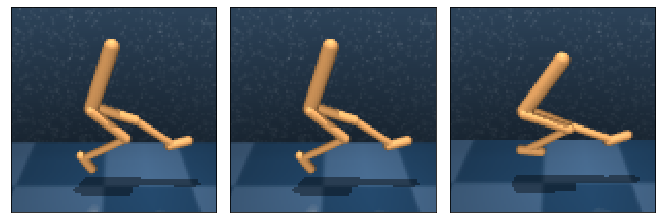

In [12]:
print_index = 1
batch_print = batch[print_index]

batch_print = batch_print.reshape(3, 3, 100, 100)
batch_print = batch_print.swapaxes(3,1).swapaxes(2,1)

show_index = 0
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9.3, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)
count = show_index
for ax in axs.flat:
    ax.imshow(batch_print[count])
    count += 1
plt.tight_layout()
plt.show()

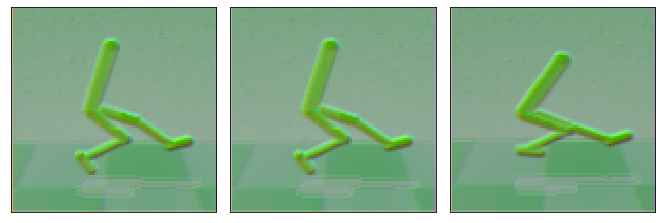

In [13]:
batch_print = rand_out[print_index]
batch_print = batch_print.reshape(3, 3, 100, 100)
batch_print.transpose_(3, 1).transpose_(2, 1)
batch_print = batch_print.data.cpu().numpy()

# normalization for visualization
for index_ in range(3):
    tensor_min = np.min(batch_print[index_])
    tensor_max = np.max(batch_print[index_])
    batch_print[index_] = batch_print[index_] + np.abs(tensor_min)
    batch_print[index_] = batch_print[index_] / np.abs(tensor_max - tensor_min)

show_index = 0
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9.3, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)
count = show_index
for ax in axs.flat:
    ax.imshow(batch_print[count])
    count += 1
plt.tight_layout()
plt.show()

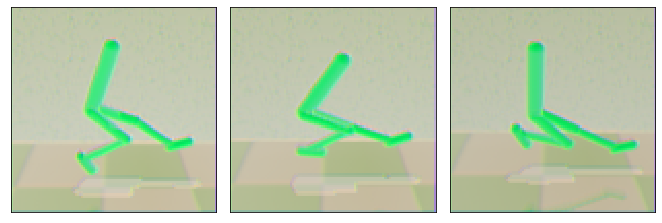

In [14]:
print_index = 2
batch_print = rand_out[print_index]
batch_print = batch_print.reshape(3, 3, 100, 100)
batch_print.transpose_(3, 1).transpose_(2, 1)
batch_print = batch_print.data.cpu().numpy()

# normalization for visualization
for index_ in range(3):
    tensor_min = np.min(batch_print[index_])
    tensor_max = np.max(batch_print[index_])
    batch_print[index_] = batch_print[index_] + np.abs(tensor_min)
    batch_print[index_] = batch_print[index_] / np.abs(tensor_max - tensor_min)

show_index = 0
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9.3, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)
count = show_index
for ax in axs.flat:
    ax.imshow(batch_print[count])
    count += 1
plt.tight_layout()
plt.show()